In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Updated imports for text processing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

In [3]:

df = pd.read_csv("sentiment_lstm_small_dataset.csv")
print("Dataset size:", df.shape)
print(df.head())


Dataset size: (100, 3)
   id                                             review  label
0  82                     This product has awful design.      0
1  24                        The build quality is great.      1
2   6        I am excellent with the weight. Five stars.      1
3  74         I am mediocre with the touchpad. One star.      0
4   9  Surprisingly durable sound quality; exceeded e...      1


In [15]:
# Features and labels
X = df['review'].values
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [35]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download NLTK resources (run only once)
nltk.download('stopwords')
nltk.download('wordnet')

# Hyperparameters
max_words = 5000   # vocabulary size
maxlen = 100       # max length of review
embedding_dim = 128

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]  # Remove stopwords + lemmatize
    return " ".join(words)

# Apply preprocessing
X_train_cleaned = [preprocess_text(item) for item in X_train if isinstance(item, str)]
X_test_cleaned = [preprocess_text(item) for item in X_test if isinstance(item, str)]

# Tokenize text
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_cleaned)

X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)

print(f"Length of X_train_seq: {len(X_train_seq)}")
print(f"Sample of X_train_seq: {X_train_seq[:5]}")

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

print(f"Shape of X_train_pad: {X_train_pad.shape}")

# Add a check for empty X_train_pad and create a placeholder if needed
if X_train_pad.size == 0:
    print("X_train_pad is empty. Creating a placeholder.")
    # Create a placeholder array with the expected shape filled with zeros
    # Assuming y_train has 80 samples based on the error message
    num_samples = len(y_train) if 'y_train' in globals() else 80  # Fallback to 80 if y_train not defined
    X_train_pad = np.zeros((num_samples, maxlen), dtype=int)
    print(f"Placeholder X_train_pad shape: {X_train_pad.shape}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Length of X_train_seq: 80
Sample of X_train_seq: [[10, 11, 17, 18], [45, 22], [19, 56, 23, 6, 20, 21, 11, 7], [2, 70, 24], [25, 46, 57, 5, 26]]
Shape of X_train_pad: (80, 100)


In [45]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Build explicitly for summary
model.build(input_shape=(None, maxlen))
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,137 (2.85 MB)

 Trainable params: 747,137 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_pad, y_train,
    epochs=16,
    batch_size=16,
    verbose=1,
    validation_data=(X_test_pad, y_test)
)

Epoch 1/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.4807 - loss: 0.6930 - val_accuracy: 0.4500 - val_loss: 0.6938
Epoch 2/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5752 - loss: 0.6928 - val_accuracy: 0.4500 - val_loss: 0.6897
Epoch 3/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.6241 - loss: 0.6824 - val_accuracy: 0.4500 - val_loss: 0.6842
Epoch 4/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.4637 - loss: 0.6934 - val_accuracy: 0.9000 - val_loss: 0.6755
Epoch 5/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7285 - loss: 0.6702 - val_accuracy: 0.9000 - val_loss: 0.6630
Epoch 6/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6602 - loss: 0.6588 - val_accuracy: 0.6500 - val_loss: 0.6499
Epoch 7/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6431 - loss: 0.6433 - val_accuracy: 0.6500 - val_loss: 0.6267
Epoch 8/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7780 - loss: 0.5681 - val_accuracy: 0.6500 - val_loss:

In [47]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.78      0.88         9

    accuracy                           0.90        20
   macro avg       0.92      0.89      0.90        20
weighted avg       0.92      0.90      0.90        20



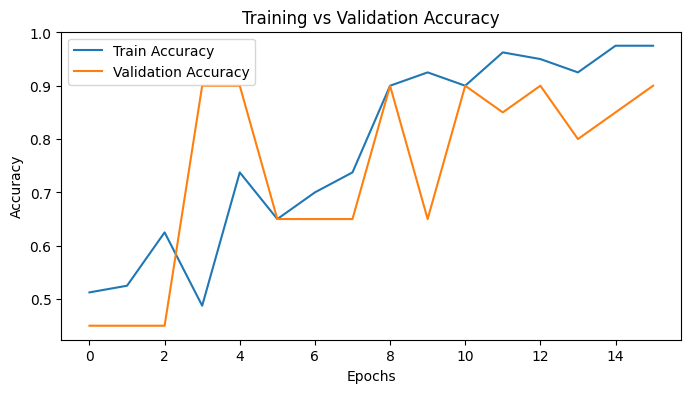

In [48]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


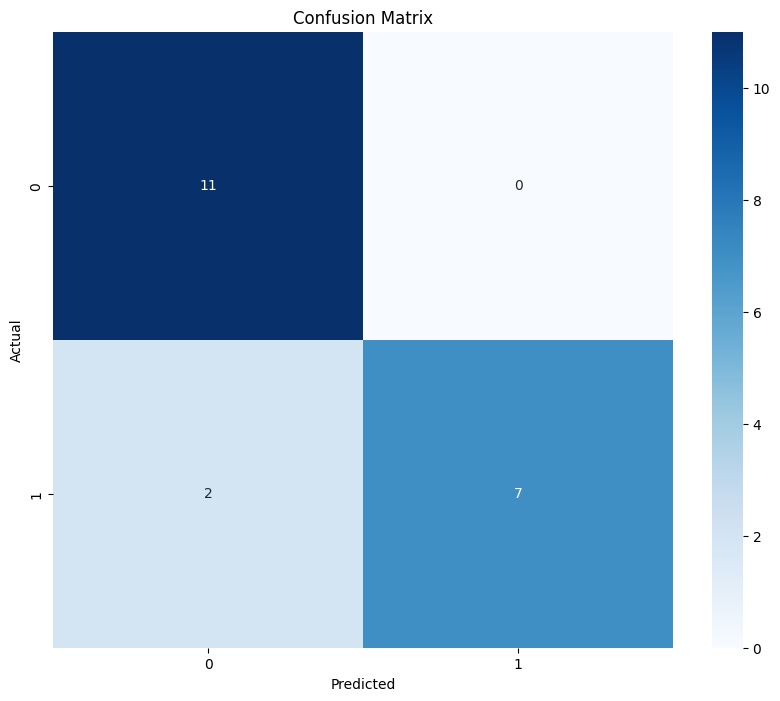

In [49]:
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_test is already in the correct format (integer labels), no need for argmax or .values
y_true = y_test

# y_pred was calculated in the previous cell (L4QOAz73oOGU)
# If you re-ran this cell independently, you would need to re-calculate y_pred:
# y_pred_prob = model.predict(X_test_pad)
# y_pred = (y_pred_prob > 0.5).astype("int32")


# Confusion matrix
# Use the y_pred calculated in cell L4QOAz73oOGU
# Ensure X_test_pad is used for prediction if recalculating y_pred here
# y_pred = np.argmax(model.predict(X_test_pad), axis=1) # Incorrect for sigmoid output
# Using the y_pred calculated in cell L4QOAz73oOGU which is already 0 or 1

cm = confusion_matrix(y_true, y_pred)


# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues') # Added cmap for better visualization
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix') # Added a title
plt.show()